##### 你會下載一筆資料包含時間、季節、是否是特別假日、是否是工作日、天氣狀況、溫度、體感溫度、濕度、風速來預測每小時的腳踏車數量。這筆資料包含完整兩年(2011,2012)的1至19日歷史租借資料，用這些資料來預測20日~月底的每小時腳踏車租借數量。每個比賽都有背後的原因，大家可以想想為什麼要辦這樣的比賽？可能的原因有：透過這些預測模型，租借腳踏車的公司就可以使用動態定價(像是Uber動態價格的機制)來獲取更多的利益，或是準備更多的腳踏車以滿足臨時大量需求。

In [1]:
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
import pandas as pd
import numpy as np
# import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns #簡易版matplotlib
import calendar
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# pd.options.mode.chained_assignment = None #忽略警告

In [2]:
#https://medium.com/jameslearningnote/%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90-%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E7%AC%AC4-2%E8%AC%9B-%E5%85%B1%E4%BA%AB%E5%96%AE%E8%BB%8A%E9%9C%80%E6%B1%82%E9%A0%90%E6%B8%AC-%E5%89%8D17-%E6%8E%92%E5%90%8D-505ed7100825
train = pd.read_csv("~/bigdata_team/data/bikeshare/train.csv")
test = pd.read_csv("~/bigdata_team/data/bikeshare/test.csv")
submit = pd.read_csv("~/bigdata_team/data/bikeshare/sampleSubmission.csv")

In [3]:
# datetime：时间。年月日小时格式
# season：季节。1：春天；2：夏天；3：秋天；4：冬天
# holiday：是否节假日。0：否；1：是
# workingday：是否工作日。0：否；1：是
# weather：天气。1：晴天；2：阴天；3：小鱼或小雪；4：恶劣天气
# temp：实际温度
# atemp：体感温度
# humidity：湿度
# windspeed：风速
# casual：未注册用户租车数量
# registered：注册用户租车数量
# count：总租车数量

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
train.describe()
# count：数量统计，此列共有多少有效值
# mean：均值
# std：标准差，資料平均值分散程度的度量。較大的標準差，代表大部分數值和其平均值之間差異較大
# min：最小值
# 25%：第一四分位數，樣本中所有數值由小到大排列後第25%的數字
# 50%：第二四分位數
# 75%：第三四分位數
# max：最大值

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
train.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16


##### 欄位count的50百分位數為145, 75百分位數為284以及 max值為977相差非常巨大，因此可以判斷有Outlier(異常值)，可以使用最簡單的超出三倍標準差概念將這些Outlier先去掉，避免對Model造成影響，去掉Outlier之後的預測分數也會明顯提升

In [7]:
print ("Shape Of The Before Outliers: ",train.shape)
train = train[np.abs(train['count']-train['count'].mean())<=(3*train['count'].std())]
print ("Shape Of The After Outliers: ",train.shape)

Shape Of The Before Outliers:  (10886, 12)
Shape Of The After Outliers:  (10739, 12)


##### 將時間處理成讓Random forest可以分析的格式，我們將時間拆成日期、小時、年、星期幾、月份的欄位（日期之後不會用到主要是用來算星期幾以及月份）。由於Train跟Test的資料都要做這樣的處理，因此我們先把Train, Test Data合併後一起處理

In [8]:
data=train.append(test)

In [9]:
data.reset_index(inplace=True)
data.head(1)

,index,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0


In [10]:
# drop刪除列或行，inplace=True直接在原数据上进行删除操作，False不改变原数据，返回一个新dataframe
data.drop('index',inplace=True,axis=1) 
data.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0


In [11]:
# data.datetime 等同 data.iloc[:,0] 等同 data.loc[:,'datetime']
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

In [12]:
data.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,year,weekday,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,2011-01-01,0,2011,5,1


#### 看數值(metric)像是溫度(temp)、體感溫度(atemp)、濕度(humidity)、風速(windspeed)的資料分佈情況
#### displot是由兩種圖組成的：直方圖＋核密度函數

<AxesSubplot:xlabel='temp', ylabel='Density'>

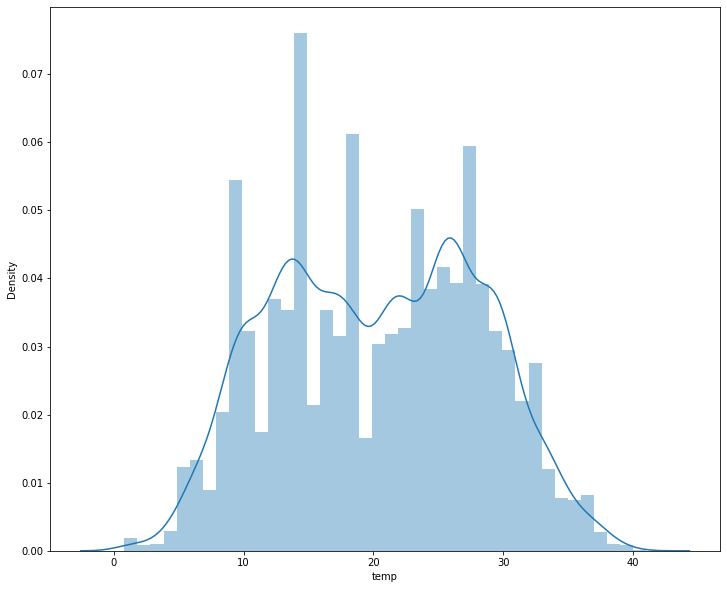

In [13]:
fig, axes = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(12, 10)
sns.distplot(data["temp"],ax=axes)

#### 在下方四張圖裡面我們可以觀察到一個非常重要的關鍵！在右下方風速的圖可以發現風速為0的值非常多，而靠近0的(大約風速6,7以內都沒有出現)，中間也出現許多沒有任何值的情況，因此可以大概推論風速0是風速太小量不到或是只要是風速為空值都被資料提供方補上0！這種的0會對大部分的模型造成預估失準，因此我們要將風速為0的值重新估計。

[Text(0.5, 0, 'windspeed'), Text(0.5, 1.0, 'distribution of windspeed')]

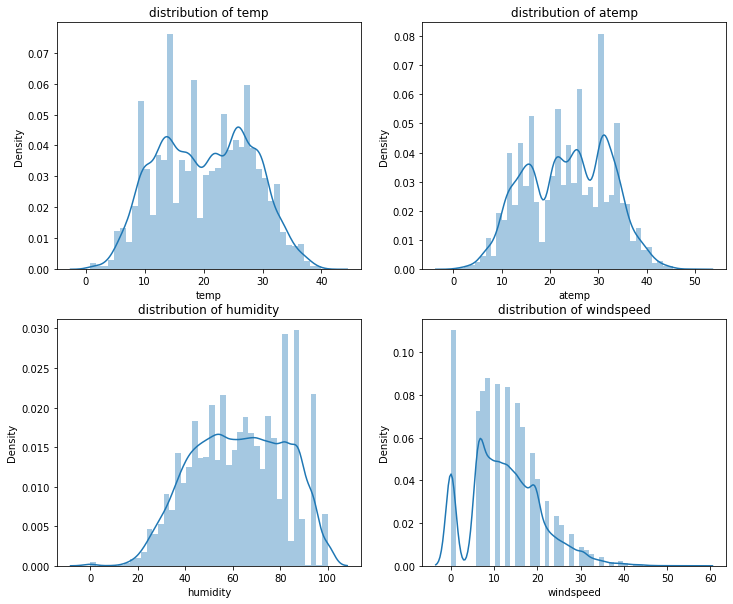

In [14]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.distplot(data["temp"],ax=axes[0][0])
sns.distplot(data["atemp"],ax=axes[0][1])
sns.distplot(data["humidity"],ax=axes[1][0])
sns.distplot(data["windspeed"],ax=axes[1][1])

axes[0][0].set(xlabel='temp',title="distribution of temp")
axes[0][1].set(xlabel='atemp',title="distribution of atemp")
axes[1][0].set(xlabel='humidity',title="distribution of humidity")
axes[1][1].set(xlabel='windspeed',title="distribution of windspeed")

#### 我們先將資料分成風速為0以及風速不為0的資料，並且用風速不為0的資料來訓練random forest的模型，將訓練好的模型來預估風速為0的風速到底是多少。由下圖中可以看到我們已將風速為0的資料重新預估後去填補了空隙，這樣的做法可以明顯提升預測的準度。

In [15]:
dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
rfModel_wind = RandomForestRegressor(n_estimators=1000,random_state=42)
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0.loc[:,"windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

<AxesSubplot:xlabel='windspeed', ylabel='Density'>

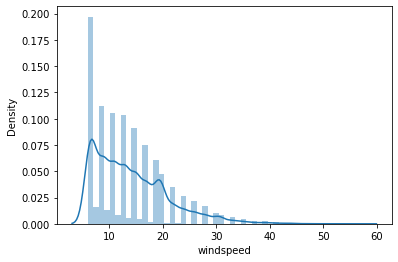

In [16]:
sns.distplot(data["windspeed"])

#### 最後一個小技巧是我們去觀察腳踏車出借數量(count)的資料分佈，可以發現原本的資料非常歪斜(Skew)，也就是不符合常態分佈。透過取Log的方式，來讓資料分布較為接近常態分佈，這樣的技巧也可以讓預估上更準確。

#### 我：取log是把數字分佈範圍縮小，類似one hot recording?

In [17]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLabelsLog = np.log(yLabels)

In [18]:
dropFeatures = ['casual',"count","datetime","date","registered"]
dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)

<AxesSubplot:xlabel='count', ylabel='Density'>

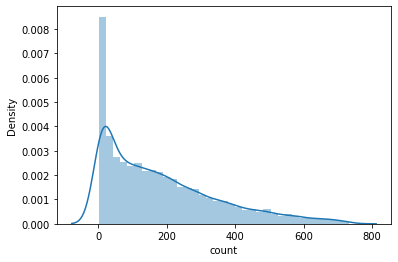

In [19]:
sns.distplot(yLabels)

#### 可以看到取Log後的資料更接近常態分佈了

<AxesSubplot:xlabel='count', ylabel='Density'>

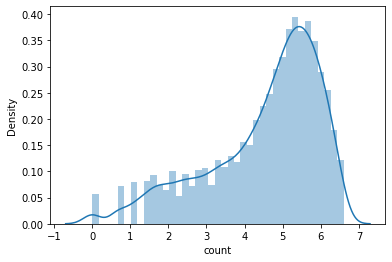

In [20]:
sns.distplot(yLabelsLog)

#### 最後將資料丟進Random forest train
#### Random forest模型的參數這邊只做了n_estimators =1000這個非常基本的設定，random_state =42主要是隨機的方式，有點像是在洗撲克牌時洗牌的方式，透過設定一個固定的值，每個人跑這隻程式輸出的結果會跟我一模一樣。這個值可以設定任何數字，42的原因是因為Kaggle上面大家很喜歡用42這個數字

In [21]:
rfModel = RandomForestRegressor(n_estimators=1000,random_state=42)
yLabelsLog = np.log(yLabels)
rfModel.fit(dataTrain,yLabelsLog)
preds = rfModel.predict(X= dataTrain)

In [22]:
predsTest = rfModel.predict(X= dataTest)
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(predsTest)]
    })
submission.to_csv('bike_predictions_RF.csv', index=False)